# **Avocado price optimization - PART 1**

As a supplier, setting an appropriate avocado price requires a delicate trade-off.
Set it too high and you lose customers. Set it too low and you won't make a profit.
Equipped with good data, the avocado pricing and supply problem is *ripe* with opportunities for demonstrating the power of optimization and data science.

**Goal**: Develop a data science pipeline for pricing and distribution of avocados to maximize revenue.

This notebook guides you through a decision-making process that leads to a mathematical optimization model. The process consists of three stages:

1. **Data Analysis**: Explore the dataset to identify relationships between categories like sales, price, region, and seasonal trends.
2. **Prediction Model**: Develop a model to forecast avocado demand based on factors such as price, region, year, and seasonality.
3. **Optimization Problem**: Formulate an optimization problem to determine the optimal price and supply quantity, aiming to maximize net revenue while accounting for costs related to wastage and transportation.


## Load the Packages and the Datasets

We use real sales data provided by the [Hass Avocado Board](https://hassavocadoboard.com/) (HAB), whose aim is to "make avocados America’s most popular fruit". This dataset contains consolidated information on several years' worth of market prices and sales of avocados.

We will now load the following packages for analyzing and visualizing the data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

## Part I: Read and explore the data

In [6]:
df = pd.read_csv('/Users/fabiosalerno/Documents/main/prescriptive-ml/notebooks/avocado /avocado.csv')
df.head()

,date,units_sold,price,region,year,month,peak
0,2015-01-04,3.382800,1.02,Great_Lakes,2015,1,0
1,2015-01-04,2.578275,1.10,Midsouth,2015,1,0
2,2015-01-04,5.794411,0.89,West,2015,1,0
3,2015-01-04,3.204112,0.98,Southeast,2015,1,0
4,2015-01-04,0.321824,1.05,Northern_New_England,2015,1,0


The dataset from HAB contains sales data for the years 2019-2022. This data is augmented by a previous download from HAB available on [Kaggle](https://www.kaggle.com/datasets/timmate/avocado-prices-2020) with sales for the years 2015-2018.

Each row in the dataset is the weekly number of avocados sold and the weekly average price of an avocado categorized by region and type of avocado. There are two types of avocados: conventional and organic. In this notebook, we will only consider the conventional avocados.
There are eight large regions, namely the Great Lakes, Midsouth, North East, Northern New England, South Central, South East, West and Plains.

Observe some trends in the data:
- Seasonality
- Correlations with the units sold
- Sales through regions

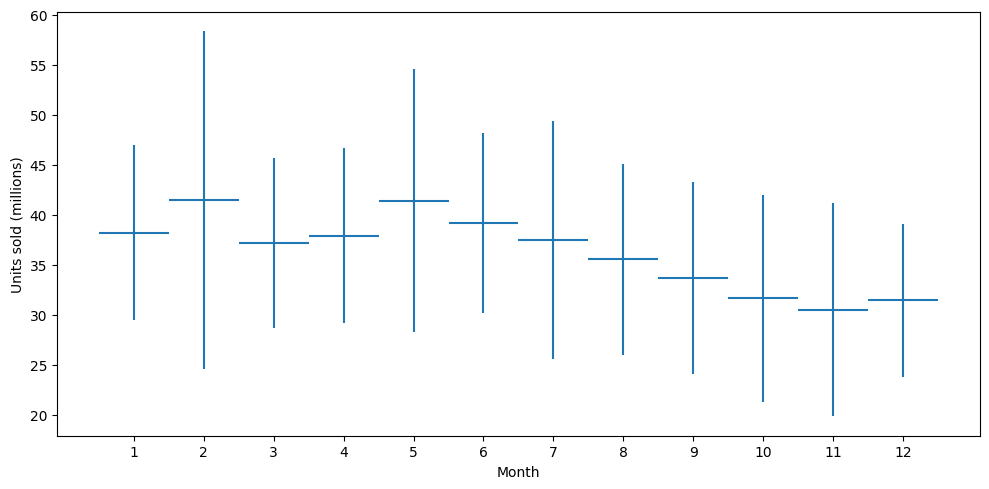

In [7]:
# seasonality
df_Total_US = df[df['region']=='Total_US']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

mean = df_Total_US.groupby('month')['units_sold'].mean()
std  = df_Total_US.groupby('month')['units_sold'].std()

axes.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='')
axes.set_ylabel('Units Sold (millions)')
axes.set_xlabel('Month')

fig.tight_layout()

plt.xlabel('Month')
axes.set_xticks(range(1,13))
plt.ylabel('Units sold (millions)')
plt.show()

We can see that the sales generally have a trend through months!

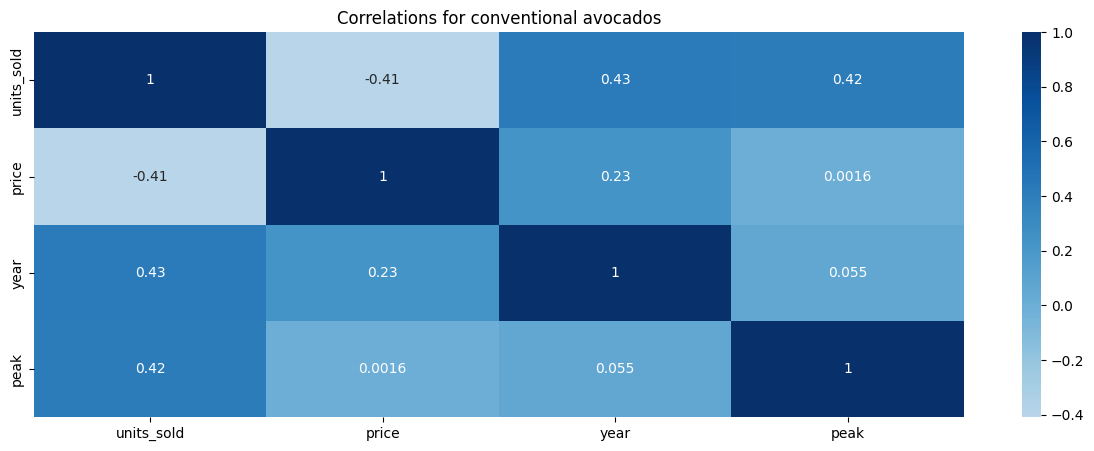

In [8]:
# Correlaitons
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.heatmap(df_Total_US[['units_sold', 'price', 'year', 'peak']].corr(),annot=True, center=0,ax=axes, cmap='Blues')

axes.set_title('Correlations for conventional avocados')
plt.show()

As expected, the sales quantity has a negative correlation with the price per avocado. The sales quantity has a positive correlation with the year and season being a peak season.

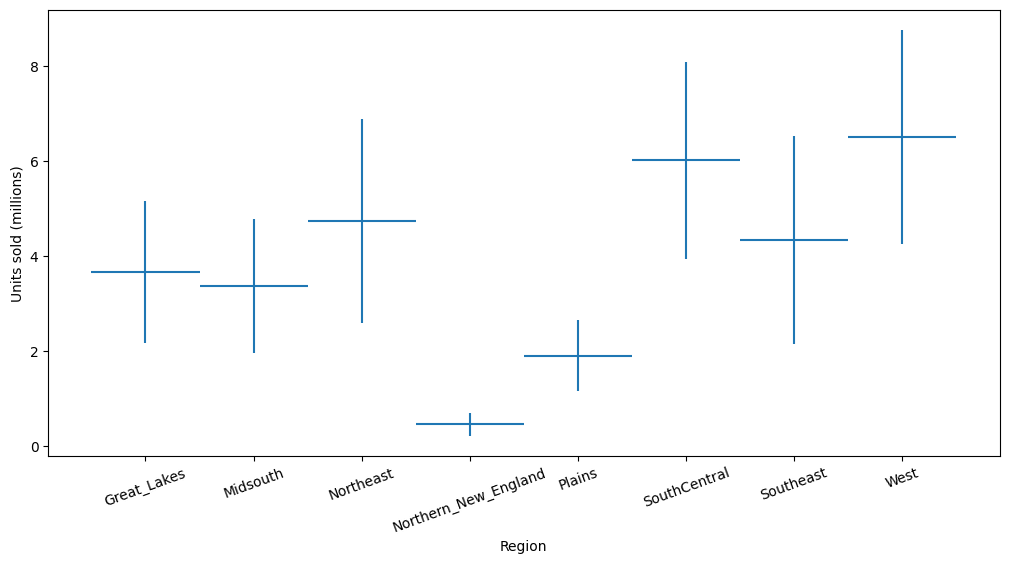

In [9]:
# sales per region


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

regions = ['Great_Lakes','Midsouth','Northeast','Northern_New_England','SouthCentral','Southeast','West','Plains']
ds = df[df.region.isin(regions)]

mean = ds.groupby('region')['units_sold'].mean()
std  = ds.groupby('region')['units_sold'].std()

axes.errorbar(range(len(mean)), mean, xerr=0.5, yerr=2*std, linestyle='')

fig.tight_layout()

plt.xlabel('Region')
plt.xticks(range(len(mean)), pd.DataFrame(mean)['units_sold'].index,rotation=20)
plt.ylabel('Units sold (millions)')
plt.show()

West-coast is the region with more sales!

## Part II: Predict the Sales

The trends observed in Part I motivate us to construct a prediction model for sales using the independent variables- price, year, region and seasonality.

Let us now construct a linear regressor for the demand.
Note that the region is a categorical variable.
The linear regressor can be mathematically expressed as:

$$demand = g(price, region, year, season) = \\ \beta_0 + \beta_1 * price + \sum\limits_{region} \beta^{region}_3 * \mathbb{1}(region)  +  \beta_4 w_{year}*year +  \beta_5  * \mathbb{1}(peak).$$

Here, the $\beta$ values are weights (or "co-efficients") that have to be learned from the data.

> *Note* that the notation $\mathbb{1}(region)$ is an indicator function that takes the value $1$ for each region in the summation. The value of $\mathbb{1}(peak)$ is $1$ if we consider the peak season.

To validate the regression model, we will randomly split the dataset into $80\%$ training and $20\%$ testing data and learn the weights using sklearns.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

# train test split
X = df[["region", "price", "year", "peak"]]
y = df["units_sold"]
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

# apply some preprocessing before feeding the data to the model
feat_transform = make_column_transformer(
    (OneHotEncoder(drop="first"), ["region"]),
    (StandardScaler(), ["price", "year"]),
    ("passthrough", ["peak"]),
    verbose_feature_names_out=False,
    remainder="drop",
)

In [11]:
# modeling to assess the performance
lin_reg = make_pipeline(feat_transform, LinearRegression())
lin_reg.fit(X_train, y_train)

# Get R^2 from test data
y_pred = lin_reg.predict(X_test)
print(f"The R^2 value in the test set is {r2_score(y_test, y_pred)}")

The R^2 value in the test set is 0.9762098510236252


In [12]:
# fitting the full dataset
y_pred_full = lin_reg.predict(X)
print(f"The R^2 value in the full dataset is {r2_score(y, y_pred_full):2.2f}")

The R^2 value in the full dataset is 0.96


We can observe a good $R^2$ value in the test set. We will now train the fit the weights to the full dataset.

## Part III: Optimize for Price and Supply of Avocados

**Input parameters**

- The US market is splitted in a set of regions $R$.
- B = 30M is the total supply (the number of  available avocados to be distributed across regions).
- Each regions has a precise demand which needs to be estimated.
- An avocado can be sold or waisted. Every waisted product has a cost $c_{waste} = 0. 10$.
- $a^r_{min}=0\$,a^r_{max}=2\$$ are the minimum and maximum price ($\$$) per avocado for reigon $r \in R$.
-$b^r_{min},b^r_{max}$ are the minimum and maximum number of avocados allocated to region $r \in R$.

- $c^r_{transport}$ is the cost ($\$$) of transporting a avocado to region $r \in R$. The cost of transporting an avocado ranges between $\$0.10$ to $\$0.50$ based on each region's distance from the southern border, where the majority of avocado supply comes from.

| Region               | Transportation Costs |
|----------------------|-------|
| Great Lakes          | 0.3   |
| Midsouth             | 0.1   |
| Northeast            | 0.4   |
| Northern New England | 0.5   |
| SouthCentral         | 0.3   |
| Southeast            | 0.2   |
| West                 | 0.2   |
| Plains               | 0.2   |


**Decision variables**
- $p_r$: the price of an avocado ($\$$) in region $r$,

- $x_r$: the number of products avocados supplied to region $r$,

- $s_r = \min \{x_r,d_r(p_r)\}$: the predicted number of avocados sold in region $r$,

- $w_r = x_r - s_r$: the predicted number of avocados wasted in region $r$

We want to maximize the **net revenue**. The revenue from sales in each region is calculated by the price of an avocado in that region multiplied by the quantity sold there. There are two types of costs incurred: the wastage costs for excess unsold avocados and the cost of transporting the avocados to the different regions.

\begin{align}
\textrm{maximize} &  \sum_{r}  (p_r * s_r - c_{waste} * w_r - c^r_{transport} * x_r)&
\end{align}

### Initialize the model (gurobi object)

In [13]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd

# Initialize the model (gurobi object solver)
model = gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-21


### Input parameters

- The US market is splitted in a set of regions $R$.
- B = 30M is the total supply (the number of  available avocados to be distributed across regions).
- Each regions has a precise demand which needs to be estimated.
- An avocado can be sold or waisted. Every waisted product has a cost $c_{waste} = 0. 10$.
- $a^r_{min}=0\$,a^r_{max}=2\$$ are the minimum and maximum price ($\$$) per avocado for reigon $r \in R$.
-$b^r_{min},b^r_{max}$ are the minimum and maximum number of avocados allocated to region $r \in R$.

- $c^r_{transport}$ is the cost ($\$$) of transporting a avocado to region $r \in R$. The cost of transporting an avocado ranges between $\$0.10$ to $\$0.50$ based on each region's distance from the southern border, where the majority of avocado supply comes from.


In [14]:
# Sets and parameters
B = 30  # total amount ot avocado supply

peak_or_not = 1  # 1 if it is the peak season; 1 if isn't
year = 2022

c_waste = 0.1  # the cost ($) of wasting an avocado

regions = [
    "Great_Lakes",
    "Midsouth",
    "Northeast",
    "Northern_New_England",
    "SouthCentral",
    "Southeast",
    "West",
    "Plains",
]

# the cost of transporting an avocado
c_transport = pd.Series(
    {
        "Great_Lakes": 0.3,
        "Midsouth": 0.1,
        "Northeast": 0.4,
        "Northern_New_England": 0.5,
        "SouthCentral": 0.3,
        "Southeast": 0.2,
        "West": 0.2,
        "Plains": 0.2,
    },
    name="transport_cost",
)

c_transport = c_transport.loc[regions]
# the cost of transporting an avocado

# Get the lower and upper bounds from the dataset for the price and the number of products to be stocked
a_min = 0  # minimum avocado price in each region
a_max = 2  # maximum avocado price in each region

# minimum and maximum number of avocados allocated to region
b_min = df.groupby("region")["units_sold"].min().rename("min_delivery") # minimum number of avocados allocated to each region
b_max = df.groupby("region")["units_sold"].max().rename("max_delivery") # maximum number of avocados allocated to each region

data = pd.concat(
    [
        c_transport,
        b_min,
        b_max,
    ],
    axis=1,
)

data = data.iloc[:-1]
data

,transport_cost,min_delivery,max_delivery
Great_Lakes,0.3,2.063574,7.094765
Midsouth,0.1,1.845443,6.168572
Northeast,0.4,2.364424,8.836406
Northern_New_England,0.5,0.219690,0.917984
SouthCentral,0.3,3.687130,10.323175
Southeast,0.2,2.197764,7.810475
West,0.2,3.260102,11.274749
Plains,0.2,1.058938,3.575499


### Decision Variables

Let us now define the decision variables.
In our model, we want to store the price and number of avocados allocated to each region. We also want variables that track how many avocados are predicted to be sold and how many are predicted to be wasted.
The following notation is used to model these decision variables, indexed for each region $r$.

**Decision variables:**

- $p_r$: the price of an avocado ($\$$) in region $r$,

- $x_r$: the number of products avocados supplied to region $r$,

- $s_r = \min \{x_r,d_r(p_r)\}$: the predicted number of avocados sold in region $r$,

- $w_r = x_r - s_r$: the predicted number of avocados wasted in region $r$

We will now add the variables to the Gurobi model.

In [15]:
# we will use gurobi-py pandas package

p = gppd.add_vars(model, data, name="price", lb=a_min, ub=a_max)   # price of avocados in each region
x = gppd.add_vars(model, data, name="x", lb="min_delivery", ub="max_delivery")  # quantity supplied to each region
s = gppd.add_vars(model, data, name="s")  # predicted amount of sales in each region for the given price
w = gppd.add_vars(model, data, name="w")   # excess wasteage in each region

Now, let's create an expression for the predicted demand in each region as a function of price. Note that apart from the price, none of the other parameters in this prediction function (such as region, year and seasonality) are decision variables, and hence can be treated as constants.

In [16]:
d = gppd.add_vars(
    model, data, lb=-gp.GRB.INFINITY, name="demand"
)  # Add variables for the regression

### Set the Objective

Next, we will define the objective function: we want to maximizing the **net revenue**. The revenue from sales in each region is calculated by the price of an avocado in that region multiplied by the quantity sold there. There are two types of costs incurred: the wastage costs for excess unsold avocados and the cost of transporting the avocados to the different regions.

The net revenue is the sales revenue subtracted by the total costs incurred. We assume that the purchase costs are fixed and are not incorporated in this model.

Using the defined decision variables, the objective can be written as follows.

**Objective**
\begin{align}
\textrm{maximize} &  \sum_{r}  (p_r * s_r - c_{waste} * w_r - c^r_{transport} * x_r)&
\end{align}

Let us now add the objective function to the model.

In [17]:
model.setObjective(
    (p * s).sum() - c_waste * w.sum() - (c_transport * x).sum(), gp.GRB.MAXIMIZE
)

### Add the Supply Constraint

**Constraints**

We now introduce the constraints. The first constraint is to make sure that the total number of avocados supplied is equal to $B$, which can be mathematically expressed as follows.

\begin{align*}
\sum_{r} x_r &= B
\end{align*}

The following code adds this constraint to the model.

In [18]:
model.addConstr(x.sum() == B)
model.update()

### Add Constraints That Define Sales Quantity



Next, we should define the predicted sales quantity in each region.
We can assume that if we supply more than the predicted demand, we sell exactly the predicted demand.
Otherwise, we sell exactly the allocated amount.
Hence, the predicted sales quantity is the minimum of the allocated quantity and the predicted demand, i.e., $s_r = \min \{x_r,d_r(p_r)\}$.
This relationship can be modeled by the following two constraints for each region $r$.

\begin{align*}
s_r &\leq x_r  \\
s_r &\leq d(p_r,r)  
\end{align*}

These constraints will ensure that the sales quantity $s_r$ in region $r$ is  greater than neither the allocated quantity nor the predicted demand. Note that the maximization objective function tries to maximize the revenue from sales, and therefore the optimizer will maximize the predicted sales quantity. This is assuming that the surplus and transportation costs are less than the sales price per avocado. Hence, these constraints along with the objective will ensure that the sales are equal to the minimum of supply and predicted demand.

Let us now add these constraints to the model.

In [19]:
# sales quantity constraint
gppd.add_constrs(model, s, gp.GRB.LESS_EQUAL, x)
gppd.add_constrs(model, s, gp.GRB.LESS_EQUAL, d)


model.update()

### Add the Wastage Constraints

Finally, we should define the predicted wastage in each region, given by the supplied quantity that is not predicted to be sold. We can express this mathematically for each region $r$.

\begin{align*}
w_r &= x_r - s_r
\end{align*}

We can add these constraints to the model.

In [20]:
# wastage constraint
gppd.add_constrs(model, w, gp.GRB.EQUAL, x - s)

model.update()

In [21]:
feats = pd.DataFrame(
    data={
        "region": regions,
        "price": p,
        "year": year,
        "peak": peak_or_not,
    },
    index=regions,
)
feats

,region,price,year,peak
Great_Lakes,Great_Lakes,<gurobi.Var price[Great_Lakes]>,2022,1
Midsouth,Midsouth,<gurobi.Var price[Midsouth]>,2022,1
Northeast,Northeast,<gurobi.Var price[Northeast]>,2022,1
Northern_New_England,Northern_New_England,<gurobi.Var price[Northern_New_England]>,2022,1
SouthCentral,SouthCentral,<gurobi.Var price[SouthCentral]>,2022,1
Southeast,Southeast,<gurobi.Var price[Southeast]>,2022,1
West,West,<gurobi.Var price[West]>,2022,1
Plains,Plains,<gurobi.Var price[Plains]>,2022,1


### Now, we just need to call `add_predictor_constr` to insert the constraints linking the features and the demand.

In [22]:
from gurobi_ml import add_predictor_constr

pred_constr = add_predictor_constr(model, lin_reg, feats, d)

pred_constr.print_stats()

Model for pipe:
96 variables
24 constraints
Input has shape (8, 4)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans            (8, 11)           24           16            0            0

lin_reg               (8, 1)           72            8            0            0

--------------------------------------------------------------------------------


### Solving the optimization

We have added the decision variables, objective function, and the constraints to the model.
The model is ready to be solved.
Before we do so, we should let the solver know what type of model this is.
The default setting assumes that the objective and the constraints are linear functions of the variables.

In our model, the objective is **quadratic** since we take the product of price and the predicted sales, both of which are variables.
Maximizing a quadratic term is said to be **non-convex**, and we specify this using a Gurobi parameter value to be $2$.
See [here](https://www.gurobi.com/documentation/9.5/refman/nonconvex.html) for more details.

In [23]:
model.Params.NonConvex = 2
model.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 23.4.0 23E224)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 49 rows, 136 columns and 192 nonzeros
Model fingerprint: 0x2a739eb0
Model has 8 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-01, 3e+01]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-01, 2e+03]
  RHS range        [1e+00, 2e+03]
Presolve removed 24 rows and 104 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 32 rows and 112 columns
Presolve time: 0.01s
Presolved: 34 rows, 33 columns, 81 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 33 continuous, 0 integer (0 binary)
Found heuristic solution: objective 41.7398621

Root relaxation: objective 5.303548e+01, 30 iterations, 0.00 seconds (0.00 work u

The solver solved the optimization problem in less than a second.
Let us now analyze the optimal solution by storing it in a Pandas dataframe.

In [24]:
# Analyzing the results from the optimization
solution = pd.DataFrame(index=regions)

solution["Price"] = p.gppd.X
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = w.gppd.X
solution["Pred_demand"] = d.gppd.X

opt_revenue = model.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(4)


 The optimal net revenue: $41.739862 million


,Price,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,1.5824,3.7890,3.7890,0.0,3.7890
Midsouth,1.4526,4.0560,4.0560,0.0,4.0560
Northeast,1.8500,4.4265,4.4265,0.0,4.4265
Northern_New_England,1.5530,0.9180,0.9180,0.0,0.9180
SouthCentral,1.7387,4.3836,4.3836,0.0,4.3836
Southeast,1.5941,4.2140,4.2140,0.0,4.2140
West,1.8492,5.1843,5.1843,0.0,5.1843
Plains,1.2825,3.0286,3.0286,0.0,3.0286


We can also check the error in the estimate of the Gurobi solution for the regression model.

In [25]:
print(
    "Maximum error in approximating the regression {:.6}".format(
        np.max(pred_constr.get_error())
    )
)

Maximum error in approximating the regression 1.77636e-15


And the computed features of the regression model in a pandas dataframe.



In [26]:
pred_constr.input_values.drop("region", axis=1)

,price,year,peak
Great_Lakes,1.582383,2022,1
Midsouth,1.452562,2022,1
Northeast,1.849995,2022,1
Northern_New_England,1.552994,2022,1
SouthCentral,1.738692,2022,1
Southeast,1.594114,2022,1
West,1.849227,2022,1
Plains,1.282455,2022,1


Let us now visualize a scatter plot between the price and the number of avocados sold (in millions) for the eight regions.

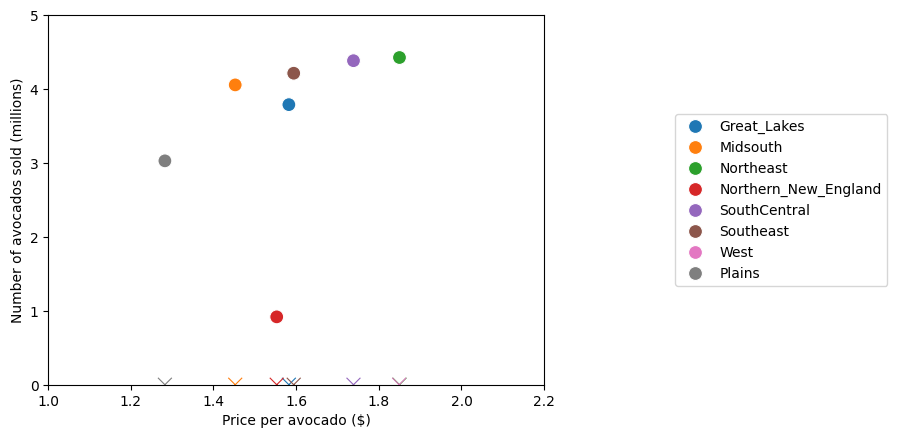

In [27]:
fig, ax = plt.subplots(1, 1)

plot_sol = sns.scatterplot(
    data=solution, x="Price", y="Sold", hue=solution.index, s=100
)
plot_waste = sns.scatterplot(
    data=solution,
    x="Price",
    y="Wasted",
    marker="x",
    hue=solution.index,
    s=100,
    legend=False,
)

plot_sol.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=1)
plot_waste.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylim(0, 5)
plt.xlim(1, 2.2)
ax.set_xlabel("Price per avocado ($)")
ax.set_ylabel("Number of avocados sold (millions)")
plt.show()

The circles represent sales quantity and the cross markers represent the wasted quantity

# **Avocado price optimization - PART 2**


In part 1, the price was estimated through a regression model. However gurobi-ml supports various scikit-learn objects. The aim of this second part is to show how easy it is to interchange different predictive models through gurobi-ml library!

Checking how the liniear regression model fits the overall dataset we can see that it has some flaws!

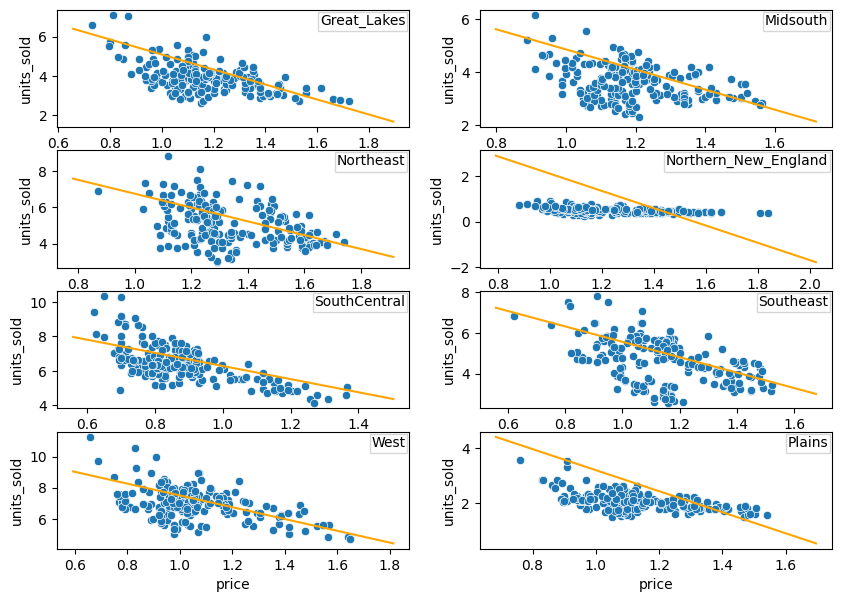

In [28]:
year = 2019
peak_or_not = 1
fig, axs = plt.subplots(4, 2, figsize=(10, 7))

for k in range(8):
  r = regions[k]
  i = k//2
  j = k%2
  X_r = df.loc[(df.region==r) & (df.peak==peak_or_not),["price", "year","units_sold"]]
  x_plt = X_r.price
  p_new = np.linspace(.9*min(x_plt),1.1*max(x_plt),50)
  x_new = pd.DataFrame(
      data={
          "year": year,
          "peak": peak_or_not,
          "region": r,
          "price": p_new
      },
      index=range(50)
  )
  x_new['units_sold'] = lin_reg.predict(x_new)
  sns.lineplot(data=x_new, x='price', y='units_sold', c='orange', ax=axs[i,j])
  sns.scatterplot(data=X_r, x='price', y='units_sold', legend=0, ax=axs[i,j])
  axs[i, j].legend(title=r, loc='upper right', prop={'size': 3}, handles = []);

## Changing the regression model

So let's try another model type and see how the fit produced, and how that will impact the optimization model!

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

Fit the model, Gradient Boosting Regressor!

In [30]:
reg = make_pipeline(feat_transform, GradientBoostingRegressor(n_estimators=100, max_leaf_nodes = 20,
                                              loss = 'absolute_error', random_state = 123))
scores = cross_val_score(reg, X_train, y_train, cv=5)
print("%0.4f R^2 with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
# Fit to entire training data
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"The R^2 value in the test set is {np.round(r2_score(y_test, y_pred),5)}")
reg.fit(X, y)
y_pred_full = reg.predict(X)
print(f"The R^2 value in the full dataset is {np.round(r2_score(y, y_pred_full),5)}")

0.9770 R^2 with a standard deviation of 0.0050
The R^2 value in the test set is 0.98718
The R^2 value in the full dataset is 0.97971


**License Restrictions**

 Gurobi uses a restricted, size-limited license, and the model size exceeds these limits, i.e., 2000 variables, 2000 linear constraints, and 200 variables if quadratic terms are present. So tu use this kind of models you need to have an academic or a commercial license. Further details on the README.md

## Update the optimization problem with the new regression model

Most of the optimization model is unchanged given the new regression model. So to update the optimization we remove the previous prediction then add the new one just as we did before.

In [31]:
# we remove the previous regression model used
pred_constr.remove()

# we add the new model to the optimization
pred_constr = add_predictor_constr(model, reg, feats, d)
model.update()

pred_constr.print_stats()


Model for pipe0:
6624 variables
824 constraints
4549 general constraints
Input has shape (8, 4)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans            (8, 11)           24           16            0            0

gbtree_reg            (8, 1)         6600          808            0         4549

--------------------------------------------------------------------------------


With the new model created, we can resolve the optimization and extract the new solution



In [32]:
model.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 23.4.0 23E224)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 849 rows, 6664 columns and 6632 nonzeros
Model fingerprint: 0xf05bf670
Model has 8 quadratic objective terms
Model has 4549 general constraints
Variable types: 936 continuous, 5728 integer (5728 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-01, 2e+03]
  RHS range        [1e+00, 2e+03]
  GenCon rhs range [1e-03, 4e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 164 rows and 0 columns
Presolve removed 0 rows and 5928 columns
Presolve time: 0.21s
Presolved: 1030 rows, 745 columns, 3497 nonzeros
Presolved model has 182 SOS constraint(s)
Presolved model has 8 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 215 continuous, 5

In [33]:
opt_revenue = model.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)


 The optimal net revenue: $49.954251 million


In [34]:
# Analyzing the results from the optimization
solution = pd.DataFrame(index=regions)

solution["Price"] = p.gppd.X
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = w.gppd.X
solution["Pred_demand"] = d.gppd.X

opt_revenue = model.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(4)


 The optimal net revenue: $49.954251 million


,Price,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,2.000,4.0088,4.0088,0.000,4.0088
Midsouth,2.000,4.6709,3.4999,1.171,3.4999
Northeast,2.000,4.9567,4.9567,0.000,4.9567
Northern_New_England,1.825,0.4770,0.4770,0.000,0.4770
SouthCentral,2.000,4.3505,4.3505,0.000,4.3505
Southeast,2.000,4.1661,4.1661,0.000,4.1661
West,2.000,5.6933,5.6933,0.000,5.6933
Plains,2.000,1.6768,1.6768,0.000,1.6768


Check how the new model fits the overall dataset



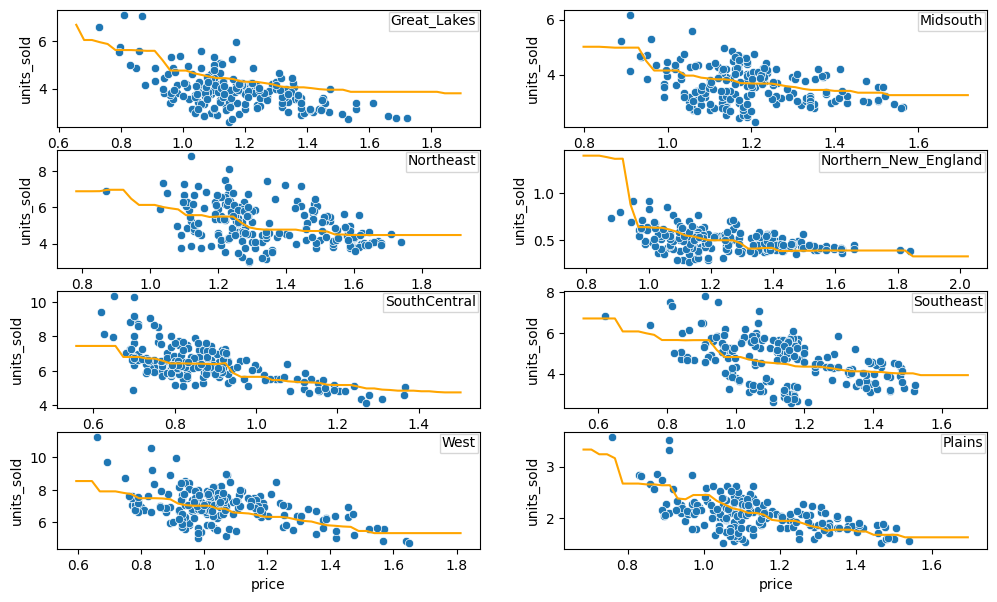

In [35]:
year = 2019
fig, axs = plt.subplots(4, 2, figsize=(12, 7))

for k in range(8):
  r = regions[k]
  i = k//2
  j = k%2
  X_r = df.loc[(df.region==r) & (df.peak==peak_or_not),["price", "year","units_sold"]]
  x_plt = X_r.price
  p_new = np.linspace(.9*min(x_plt),1.1*max(x_plt),50)
  x_new = pd.DataFrame(
      data={
          "year": year,
          "peak": peak_or_not,
          "region": r,
          "price": p_new
      },
      index=range(50)
  )
  x_new['units_sold'] = reg.predict(x_new)
  sns.lineplot(data=x_new, x='price', y='units_sold', c='orange', ax=axs[i,j])
  sns.scatterplot(data=X_r, x='price', y='units_sold',legend=0, ax=axs[i,j])
  axs[i, j].legend(title=r, loc='upper right', prop={'size': 3}, handles = []);

You can change the regression model used with the one you prefer from the supported ones by Gurobi: [link to the full list](https://gurobi-machinelearning.readthedocs.io/en/stable/user/supported.html#id1)